# SCS 3546 - TA project - StackedGAN

---
- **Implementation of StackedGAN using keras:**
    - The purpose is to generate a syntetic high resolution image of target based on the the features extracted in the higher level GANs.
    - Model consists of a top-down stack of GANs, each learned to generate a representations conditioned on higher-level representations.
    - The model is designed to double the image size after each stack. (32 * 32 -> 64 * 64 -> 128 * 128)
---


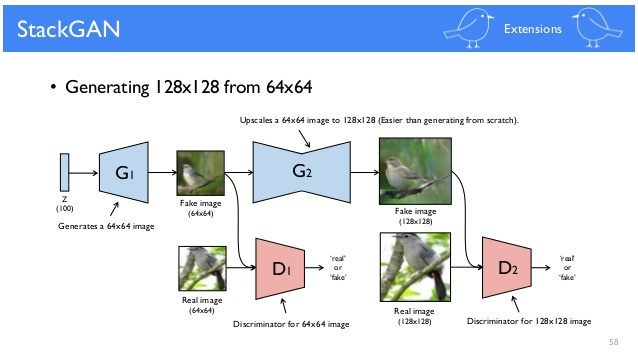
    
Image from : https://www.slideshare.net/NaverEngineering/1-gangenerative-adversarial-network

- **Challenges I faced while experimenting with different datasets or hyperparameter tuning:**
     - Model stopped learning:
         - In this example the model stopped diverging after a few epochs.
         - the model appears to be very sensitive to hyperparameters and slight change causes the model to stop diverging.

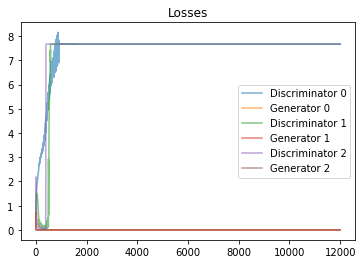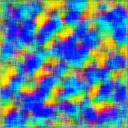

- Model started oscillating and the syntetic target never passed learning low level feature:
    - In this example I used 13000 images of dogs for training and after 6000 Epochs the images are at first deceivingly look like dogs but when examining closely the generated images are an amalgamation of dogs and their background. 

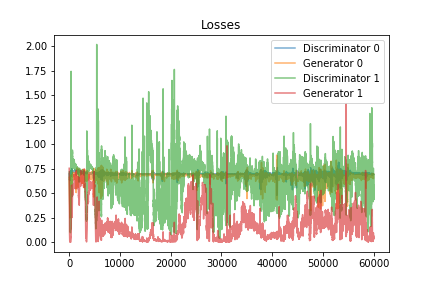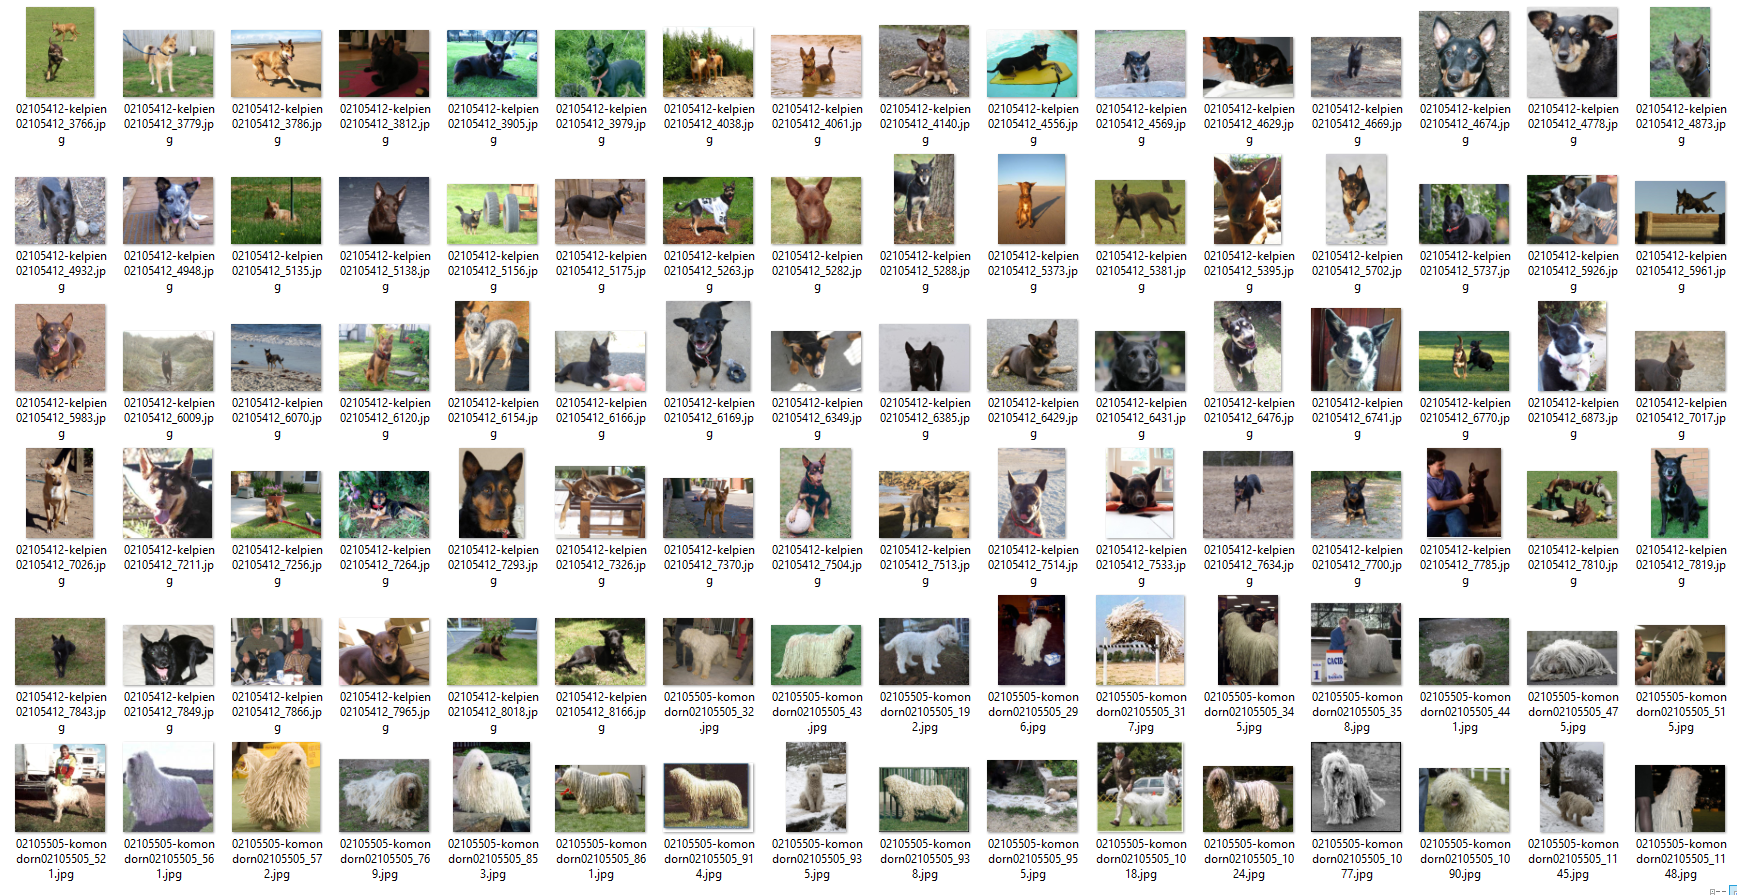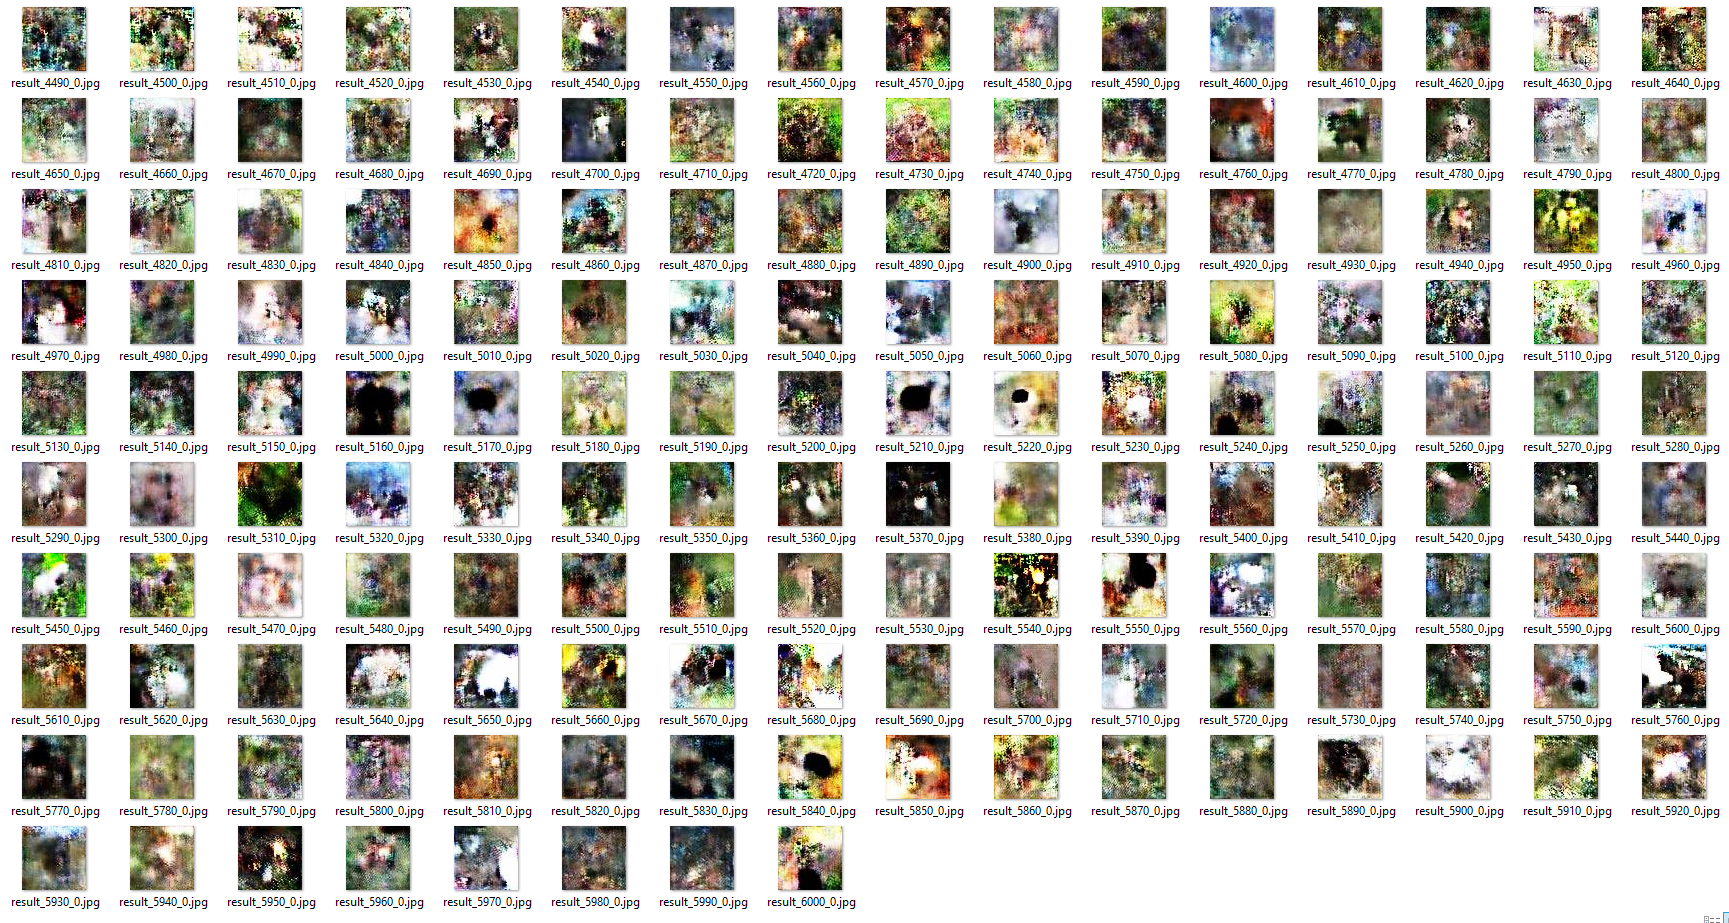

# Training progress :
    - In this example I used a few images of Mona Lisa as training set and saved the generated images after every epoch. 
    - After 3000 epochs the model seems to have learned the most important features of the training dataset and generated what looks like the pencil drawing of mona lisa. The model seemed to be oscillating between fine grained and wavy images after that.

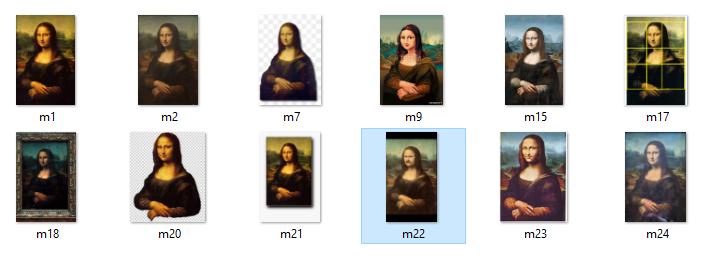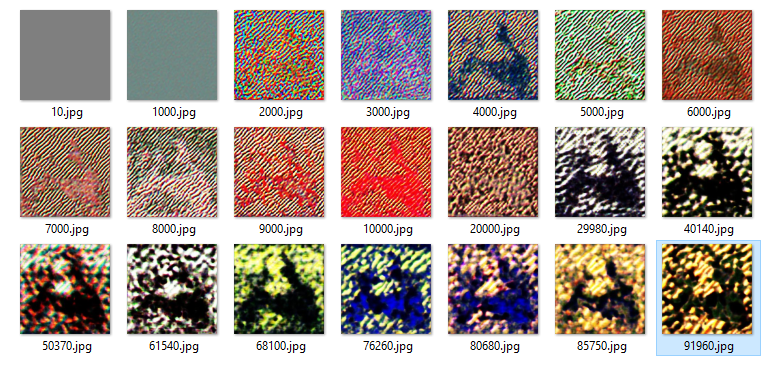

This project is inspired by https://github.com/kcct-fujimotolab/minimum-StackGAN

In [1]:
import os
import sys
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from PIL import Image

from IPython.display import clear_output
from argparse import ArgumentParser
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import save_model

from utils.file import load_complete_model
from utils.image import save_images, to_dirname
from utils.generation import generate
from utils.training import train_stacks

from networks.leakyrelu_Ver2 import build_generator, build_upsampler, build_discriminator, build_GAN
%matplotlib inline

C:\Users\alire\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\alire\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\alire\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\alire\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
input_dim = 100 # Dimension of latent vector
number_of_stacks = 2 # Number of GAN stacks
batch = 4 # Number of images in a batch
steps_in_batch = 2 # Number of steps to train on batch
epochs = 10 
save_freq = 1 # how often to save a sample output. 
image_size = [64*3,64*3] # Output size of the first GAN. After this every GAN will double it's input as it's output.

input_dirname = to_dirname('.\\ImagesUsed') # Save the training images here
output_dirname = to_dirname('.\\Output') # Expect the output images in here


# Helper functions :

def image_generator(name, size_list, ext='.jpg'):
    while True:
        try:
            list_of_files=os.listdir(name)
        except:
            continue
        random.shuffle(list_of_files)
        for file in list_of_files:
            if os.path.splitext(file)[1].lower() != ext.lower():
                continue
            try:
                img = Image.open(name+file)
            except:
                continue
            if img.mode != "RGB":
                img.convert("RGB")
            image_list=[]
            for i in range(len(size_list)):
                ss=size_list[i]
                one_image = img.resize(ss)
                one_image = np.array(one_image)
                one_image = one_image / 255.
                image_list.append(one_image)
            yield image_list
            
def get_one_batch(images_iter, batch_size=64):
    images = []
    for step in range(batch_size):
        a=next(images_iter)
        images.append(a)
    return images

def summarize_epoch(d_losses, gan_losses, epoch, epochs, duration):
    print("Epoch {}/{}".format(epoch, epochs),
          "\nDuration: {:.5f}".format(duration),
          "\nD Loss: {:.5f}".format(np.mean(d_losses[:])),
          "\nGAN Loss: {:.5f}".format(np.mean(gan_losses[:])))
    fig, ax = plt.subplots()
    for i in range(number_of_stacks):
        plt.plot(d_losses[i], label='Discriminator '+str(i), alpha=0.6)
        plt.plot(gan_losses[i], label='Generator '+str(i), alpha=0.6)
    plt.title("Losses")
    plt.legend()
    plt.savefig(output_dirname + "losses_" + str(epoch) + ".png")
    plt.show()
    plt.close()

def write_status(a_string):
    sys.stdout.write(a_string)
    sys.stdout.flush()

In [3]:
import os, re, os.path
import glob

# Clean up the old results:

for img_path in glob.glob('.\\*.h5'):
    os.remove(img_path)

mypath = '.\\Output'
for root, dirs, files in os.walk(mypath):
    for file in files:
        os.remove(os.path.join(root, file))

In [4]:
image_sizes=[]
for i in range(number_of_stacks):
    if i==0:
        image_sizes.append((image_size[0], image_size[1]))
    else:
        a=(image_sizes[i-1][0]*2, image_sizes[i-1][1]*2)
        image_sizes.append(a)
print("These are the output size of each GAN:")
print(image_sizes)

These are the output size of each GAN:
[(192, 192), (384, 384)]


In [5]:
Gs=[]
Ds=[]
GANs=[]

d_losses = []
gan_losses = []
cum_d_loss = 0
cum_gan_loss = 0

for i in range(number_of_stacks):
    d_losses.append([])
    gan_losses.append([])
    
for i in range(number_of_stacks):
    if i==0:
        G = build_generator(input_dim=input_dim, output_size=image_sizes[i])
    else:
        G = build_upsampler(input_size=image_sizes[i-1])
    Gs.append(G)
    n_gen_trainable = len(G.trainable_weights)
    #print(str(i)+' n_G_trainable='+str(n_gen_trainable))
    
    
    D = build_discriminator(input_size=image_sizes[i])
    Doptimizer = Adam(lr=1e-5, beta_1=0.1)
    D.compile(loss='binary_crossentropy', optimizer=Doptimizer)
    Ds.append(D)
    n_disc_trainable = len(D.trainable_weights)
    #print(str(i)+' n_D_trainable='+str(n_disc_trainable))
    
    GAN = build_GAN(G, D)
    GANoptimizer = Adam(lr=1e-4, beta_1=0.5)
    GAN.compile(loss='binary_crossentropy', optimizer=GANoptimizer)
    GANs.append(GAN)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
for i in range(number_of_stacks):
    print('GENERATOR='+str(i))
    Gs[i].summary()
    print('D='+str(i))
    Ds[i].summary()
    print('GAN='+str(i))
    GANs[i].summary()

GENERATOR=0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
dense_1 (Dense)              (None, 73728)             18948096  
_________________________________________________________________
batch_normalization (BatchNo (None, 73728)             294912    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 73728)             0         
_________________________________________________________________
reshape (Reshape)            (None, 24, 24, 128)       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 48, 48, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 

Epoch 1/10 10 - Training stack=2 of 2            
Duration: 35.10142 
D Loss: 1.78586 
GAN Loss: 0.37889


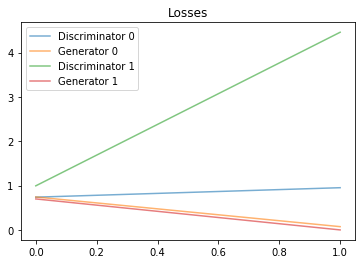

Epoch 2/10 10 - Training stack=2 of 2            
Duration: 51.33558 
D Loss: 2.71729 
GAN Loss: 0.19210


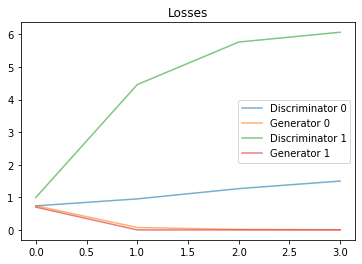

Epoch 3/10 10 - Training stack=2 of 2            
Duration: 68.05488 
D Loss: 3.02422 
GAN Loss: 0.12872


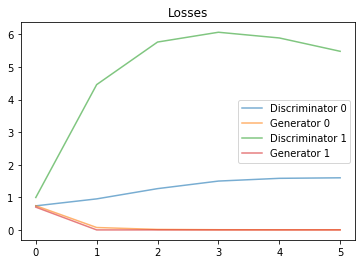

Epoch 4/10 10 - Training stack=2 of 2            
Duration: 84.74826 
D Loss: 3.04583 
GAN Loss: 0.09706


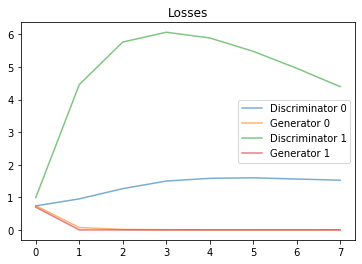

Epoch 5/10 10 - Training stack=2 of 2            
Duration: 102.95957 
D Loss: 2.93364 
GAN Loss: 0.07825


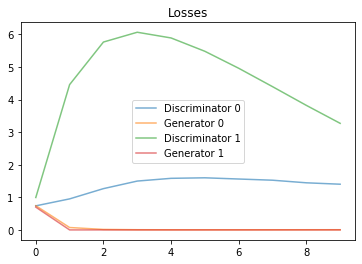

Epoch 6/10 10 - Training stack=2 of 2            
Duration: 120.29123 
D Loss: 2.77679 
GAN Loss: 0.06605


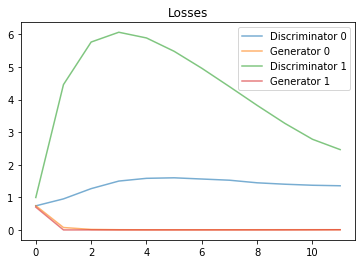

Epoch 7/10 10 - Training stack=2 of 2            
Duration: 136.97663 
D Loss: 2.64250 
GAN Loss: 0.05741


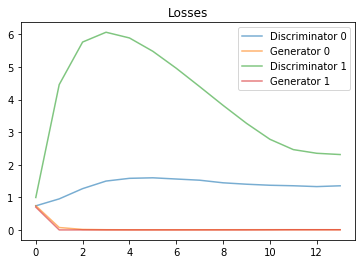

Epoch 8/10 10 - Training stack=2 of 2            
Duration: 153.29700 
D Loss: 2.53527 
GAN Loss: 0.05084


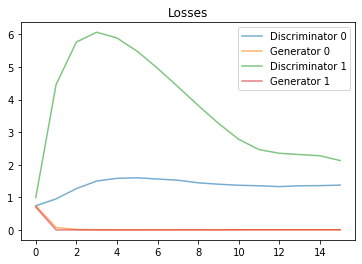

Epoch 9/10 10 - Training stack=2 of 2            
Duration: 170.47109 
D Loss: 2.45536 
GAN Loss: 0.04573


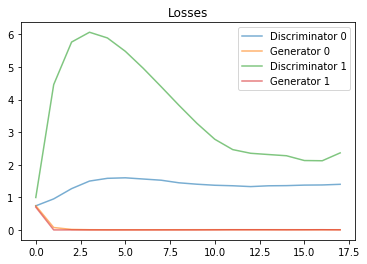

Epoch 10/10 10 - Training stack=2 of 2            
Duration: 187.91146 
D Loss: 2.39105 
GAN Loss: 0.04152


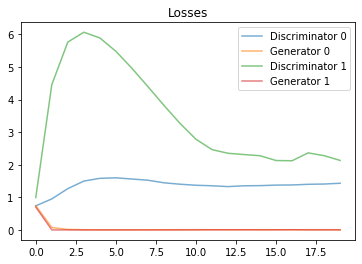

In [7]:
image_iterator=image_generator(name=input_dirname, size_list=image_sizes, ext='.jpg')
    
start_time = time.time()

for epoch in range(epochs):
    write_status('epoch=' + str(epoch+1) + ' of ' + str(epochs) + ' - Importing Images                '+ '\r')
    images=get_one_batch(images_iter=image_iterator, batch_size=(batch*steps_in_batch))
    
    write_status(' - Slicing                            '+ '\r')
    for i in range(number_of_stacks):
        slice1 = [images[ii][i] for ii in range(len(images))]
        slice1 = np.array(slice1, dtype=np.float64)

        write_status('epoch=' + str(epoch+1) + ' of ' + str(epochs) + ' - Training stack=' + str(i+1) + ' of ' + str(number_of_stacks) + '\r')
        d_losses[i], cum_d_loss, gan_losses[i], cum_gan_loss = train_stacks(epoch, number_of_stacks, i, Gs, Ds[i], GANs[i], slice1, batch, d_losses[i], cum_d_loss, gan_losses[i], cum_gan_loss)
    
    if (epoch + 1) % save_freq == 0:
        noise = np.random.uniform(0, 1, (1, input_dim))
        for i in range(number_of_stacks):
            if i==0:
                results = generate(Gs[i], source=noise)
                save_images(results, name=output_dirname+'Stage'+str(i), epoch=epoch+1)
            else:
                results = generate(Gs[i], source=results/255.)
                save_images(results, name=output_dirname+'Stage'+str(i), epoch=epoch+1)
        summarize_epoch(d_losses, gan_losses, epoch+1, epochs, time.time()-start_time)
    
    if (epoch + 1) % 100 == 0:
        write_status('epoch=' + str(epoch+1) + ' of ' + str(epochs) + ' - Saving Models'+ '\r')
        for i in range(number_of_stacks):
            Gs[i].save('Gs'+str(i)+'_model.H5')
            Ds[i].save('Ds'+str(i)+'_model.H5')
            GANs[i].save('GANs'+str(i)+'_model.H5')
        

In [8]:
def make_video(outvid, images=None, fps=30, size=None, is_color=True, format="FMP4"):
    """
    Create a video from a list of images.
 
    @param      outvid      output video
    @param      images      list of images to use in the video
    @param      fps         frame per second
    @param      size        size of each frame
    @param      is_color    color
    @param      format      see http://www.fourcc.org/codecs.php
    @return                 see http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
 
    The function relies on http://opencv-python-tutroals.readthedocs.org/en/latest/.
    By default, the video will have the size of the first image.
    It will resize every image to this size before adding them to the video.
    """
    from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
    fourcc = VideoWriter_fourcc(*format)
    vid = None
    for image in images:
        if not os.path.exists(image):
            raise FileNotFoundError(image)
        img = imread(image)
        if vid is None:
            if size is None:
                size = img.shape[1], img.shape[0]
            vid = VideoWriter(outvid, fourcc, float(fps), size, is_color)
        if size[0] != img.shape[1] and size[1] != img.shape[0]:
            img = resize(img, size)
        vid.write(img)
    vid.release()
    return vid

import glob
import os


VIDEO_DIR = '.\\Output\\'
VIDEO_SAVE_DIR = '.\\Output\\Stage0\\'
images = list(glob.iglob(os.path.join(VIDEO_SAVE_DIR, '*.*')))
# Sort the images by integer index
images = sorted(images, key=lambda x: float(os.path.split(x)[1][:-3]))
outvid = os.path.join(VIDEO_DIR, "Vid_Out.mp4")
make_video(outvid, images, fps=30)

<VideoWriter 0000027332AF0E90>

In [ ]:
#!jupyter nbextension enable --py widgetsnbextension
from tensorflow.keras.models import load_model
import ipywidgets as widgets
from IPython.display import clear_output
import numpy as np
from utils.generation import generate
from PIL import Image

input_dim = 100
G0 = load_model('Gs0_model.H5')
G1 = load_model('Gs1_model.H5')

noise = np.random.uniform(0, 1, (1, input_dim))

x=widgets.IntSlider(
    value=5,
    min=0,
    max=99,
    step=1,
    description='Vector:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

y=widgets.FloatSlider(
    value=0.5,
    min=0.0,
    max=1.0,
    step=0.1,
    description='Value:',
    disabled=False,
    continuous_update=True,
    orientation='vertical',
    readout=True,
    readout_format='.1f',
)

from matplotlib import pyplot as plt
import cv2

def show_images(images1, images2):
    %matplotlib qt 
    fig=plt.figure(figsize=(11, 7))
    images1 = images1.astype(np.uint8)
    images2 = images2.astype(np.uint8)
    for i in range(len(images1)):
        image1 = Image.fromarray(images1[i])
        image2 = Image.fromarray(images2[i])
        #fig.add_subplot(1, 1, 1)
        #plt.imshow(image1)
        fig.add_subplot(1, 3, 2)
        plt.imshow(image2)
        plt.title(noise[0])
        
    plt.show()

def test_image_generation(x, y):
    noise[0, x.value]=y.value
    results1 = generate(G0, source=noise)
    results2 = generate(G1, source=results1)
    show_images(results1, results2)

def handle_slider_change(change):
    test_image_generation(x, y)

x.observe(handle_slider_change, names='value')
y.observe(handle_slider_change, names='value')
display(x)
display(y)